## 1. Introduction

In [1]:
# Libraries
import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.layers import Dense
from keras.models import Sequential
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import (cross_val_score, cross_validate,
                                     train_test_split)
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

In [2]:
# Load data
fault = pd.read_csv('data/fault_data.csv', parse_dates=['DateTime'])
scada = pd.read_csv('data/scada_data.csv', parse_dates=['DateTime'])
status = pd.read_csv('data/status_data.csv', parse_dates=['Time'])

In [11]:
# Fault dataset
fault.head(5)

,DateTime,Time,Fault
0,2014-05-14 14:39:44,1.400096e+09,GF
1,2014-05-14 14:50:24,1.400097e+09,GF
2,2014-05-14 14:58:56,1.400098e+09,GF
3,2014-05-14 15:09:36,1.400098e+09,GF
4,2014-05-14 15:20:16,1.400099e+09,GF


In [10]:
# Scada dataset
scada.head(5)

,DateTime,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Rectifier cabinet temp.,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev
0,2014-05-01 00:00:00,1398920448,0,6.9,9.4,2.9,0.0,0.02,0.0,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
1,2014-05-01 00:09:00,1398920960,0,5.3,8.9,1.6,0.0,0.01,0.0,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
2,2014-05-01 00:20:00,1398921600,0,5.0,9.5,1.4,0.0,0.04,0.0,0,...,24,20,25,12,14,24,34,2501,25.272728,1.103713
3,2014-05-01 00:30:00,1398922240,0,4.4,8.3,1.3,0.0,0.08,0.0,0,...,23,21,25,12,14,24,34,2501,25.272728,1.103713
4,2014-05-01 00:39:00,1398922752,0,5.7,9.7,1.2,0.0,0.05,0.0,0,...,23,21,25,12,14,23,34,2501,25.272728,1.103713


#### *SCADA* x

The scada dataset has the sensors readings of the entire system in over 49k entries including the faulty state of the wind turbine as well. The sensors data are registered in a total of 66 readings as following:

WEC = Wind Energy Convertor        
RTU = Remote Terminal Unit

66 columns:
- average, max, min wind speed
- average, max, min rotation
- average, max, min power
- average nacel position including cable twisting
- operating hours
- production kWh
- production minutes
- average, max, min reactive power
- average available power from wind
- average available power technical reasons
- average available power force majeure reasons
- average available power force external reasons
- average blade angle A
- system 1,2 inverter 1-7 cabinet temperature
- spinner temperature
- front, rear bearing temperature
- pitch cabinet blade A,B,C temperature
- blade A,B,C temperature
- rotor temperature 1,2
- stator temperature 1,2
- nacelle ambient temperature 1,2
- nacelle temperature
- nacelle cabinet temperature
- main carrier temperature
- rectifier cabinet temperature
- yaw inverter temperature
- fan inverter cabinet temperature
- ambient temperature
- tower temperature
- control cabinet temperature
- transformer temperature
- average setpoint RTU
- inverter averages
- inverter standard deviations


In [12]:
# Status dataset
status.head(5)

,Time,Main Status,Sub Status,Full Status,Status Text,T,Service,FaultMsg,Value0
0,2014-04-24 12:37:38,0,0,0 : 0,Turbine in operation,1,False,False,7.4
1,2014-04-25 19:27:24,71,104,71 : 104,Insulation monitoring : Insulation fault Phase U2,6,False,True,20.5
2,2014-04-26 09:30:13,8,0,8 : 0,Maintenance,6,True,False,17.1
3,2014-04-26 10:05:19,8,0,8 : 0,Maintenance,6,False,False,8.7
4,2014-04-26 10:05:25,8,0,8 : 0,Maintenance,6,True,False,10.6


The status dataset is has 1849 entries on the wind turbine status. To be noted that the data is not on a 10 minute interval compared to the other two datasets, resulting in many missing data if the status dataset is added to the scada set. The *Full Status* data will create issues as algorithms will try to convert to float and 0:0 will result in an error. However, the *Full Status* values is the *Main Status* and *Sub Status*, therefore, it can be dropped with no loss of information. The *Full Status* and *Status Text* seem to match by unique values, but will require further analysis.

The attributes *T*, *Service*, *FaultMsg*, and *Value0* , at first look, are not self-explicative on the information that are storing, which will need an extensive study.

## 2. Data Cleaning

In [23]:
# check for na values
status[status.isnull().any(axis = 1)]

,Time,Main Status,Sub Status,Full Status,Status Text,T,Service,FaultMsg,Value0


#### 2.1 Data types

In [26]:
# Check the data types of fault dataset
fault.dtypes

DateTime    datetime64[ns]
Time               float64
Fault               object
dtype: object

In [27]:
# Check the data types of scada dataset
scada.dtypes

DateTime                 datetime64[ns]
Time                              int64
Error                             int64
WEC: ava. windspeed             float64
WEC: max. windspeed             float64
                              ...      
Control cabinet temp.             int64
Transformer temp.                 int64
RTU: ava. Setpoint 1              int64
Inverter averages               float64
Inverter std dev                float64
Length: 66, dtype: object

In [28]:
# Check the data types of status dataset
status.dtypes

DateTime       datetime64[ns]
Main Status             int64
Sub Status              int64
Full Status            object
Status Text            object
T                       int64
Service                  bool
FaultMsg                 bool
Value0                float64
dtype: object

In [3]:
# Changing the type of 'Time' column from float to int, to be of same format as 'Time' in the 'scada' dataset - Unix Timestamp
fault.Time = fault.Time.astype(int)

In [4]:
# Rename column 'Time' to 'DateTime' in status dataframe to match the other two dataframes
status.rename({'Time' : 'DateTime'}, axis = 1, inplace = True)

### 3. Exploratory Data Analysis

#### 3.1. Nominal attributes

In [5]:
fault_types = fault.groupby('Fault')

fault_types = fault_types.agg({'count'})['Time']

fault_types

,count
Fault,
AF,62
EF,174
FF,254
GF,43
MF,20


In [6]:
status_meaning = status.groupby(['Status Text', 'Full Status'])

status_meaning = status_meaning.agg({'count'})['DateTime']

status_meaning

,,count
Status Text,Full Status,
Air gap monitoring : Sensor 1 blade C,72 : 301,1
Cable twisted : Left (2-3 turns),21 : 1,1
Cable twisted : Right (2-3 turns),21 : 2,11
Calibration of load control,0 : 5,68
Data bus error (Timeout) : Fan inverter,304 : 56,1
Data bus error all inverters,204 : 0,5
Data bus error blade control (timeout) : Blade load control B,307 : 14,1
Excitation error : Overvoltage DC-link,80 : 21,84
Feeding control bus error (Bus-Off) : I/O-board control cabinet,301 : 81,3


In [8]:
# Fix Sub Status from 2 to 1 where Status Text = 'Lack of wind : Wind speed to low' 
scada['Sub Status' == 2] = 1

# Fix Main Status from 66 to 62 (66 is the only value) and change 32 into 919 for Sub Status
scada['Main Status' == 66] = 62
scada['Sub Status' == 32] = 919

In [11]:
# Check if by adding status to fault will create many missing data
fault_extended = scada.merge(status, on = 'DateTime', how = 'inner' )
fault_extended

,DateTime,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Inverter std dev,False,Main Status,Sub Status,Full Status,Status Text,T,Service,FaultMsg,Value0
0,2014-09-06,1409979648,0,2.700000,3.500000,2.2,5.71,6.11,5.43,29,...,2.686667,919,228,100,228 : 100,Timeout warnmessage : Malfunction aircooling,6,False,True,9.4
1,2014-10-06,1412571648,0,17.799999,24.900000,8.8,14.16,15.09,12.75,3065,...,1.863526,919,228,100,228 : 100,Timeout warnmessage : Malfunction aircooling,6,False,True,7.4
2,2014-11-06,1415253632,0,11.300000,15.700000,8.1,13.84,14.67,12.09,2816,...,2.013590,919,228,100,228 : 100,Timeout warnmessage : Malfunction aircooling,6,False,True,7.5
3,2014-12-06,1417845632,0,7.400000,8.400000,6.2,10.16,10.85,9.66,903,...,1.433368,919,228,100,228 : 100,Timeout warnmessage : Malfunction aircooling,6,False,True,3.7
4,2015-01-15,1421301632,0,13.000000,17.200001,9.4,14.69,15.04,14.18,2426,...,1.814086,919,228,100,228 : 100,Timeout warnmessage : Malfunction aircooling,6,False,True,17.9
5,2015-01-16,1421388032,0,5.700000,7.200000,4.1,8.42,9.12,7.59,452,...,3.188046,919,228,100,228 : 100,Timeout warnmessage : Malfunction aircooling,6,False,True,8.3


#### 3.2. Time Series analysis
There are three different datasets on different time scales. Therefore it is worth seeing the timespan of the three datasets.

(0.0, 4.0)

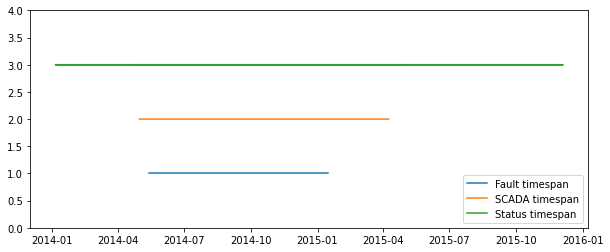

In [6]:
# Ploting the timespans
plt.figure(figsize = (10, 4))
plt.plot(fault.DateTime, np.full(len(fault), 1), label = 'Fault timespan')
plt.plot(scada.DateTime, np.full(len(scada), 2), label = 'SCADA timespan')
plt.plot(status.DateTime, np.full(len(status), 3), label = 'Status timespan')
plt.legend(loc = 'lower right')
plt.ylim(0, 4)

The data of the status is over a longer period of time compared to the rest of the datasets. Although, only part of it will be used, namely, the entries matching the entries in SCADA dataframe. 

### Combining datasets

In [5]:
data = scada.merge(fault, on = 'Time', how = 'outer')
data[-data.isna().any(axis = 1)]

,DateTime_x,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,DateTime_y,Fault
1945,2014-05-14 14:39:00,1400096384,0,5.7,7.400000,4.1,9.98,10.23,9.72,0,...,27,17,26,35,34,2501,25.818182,0.603023,2014-05-14 14:39:44,GF
1946,2014-05-14 14:50:00,1400097024,0,6.4,8.600000,2.7,4.12,10.71,0.70,0,...,27,17,26,35,34,2501,26.090910,0.943880,2014-05-14 14:50:24,GF
1947,2014-05-14 14:58:00,1400097536,0,5.6,7.500000,4.0,9.99,10.20,9.80,0,...,27,17,26,35,34,2501,26.454546,0.820200,2014-05-14 14:58:56,GF
1948,2014-05-14 15:09:00,1400098176,0,5.3,6.600000,4.1,9.98,10.17,9.79,0,...,27,18,26,35,34,2501,26.181818,0.873863,2014-05-14 15:09:36,GF
1949,2014-05-14 15:20:00,1400098816,0,5.1,7.200000,3.8,9.99,10.17,9.80,0,...,28,18,26,35,34,2501,26.181818,0.981650,2014-05-14 15:20:16,GF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37075,2015-01-14 23:00:00,1421298048,0,13.5,22.000000,7.7,14.69,15.19,13.83,2736,...,24,8,29,35,57,3050,25.909090,1.814086,2015-01-14 23:00:48,AF
37076,2015-01-14 23:09:00,1421298560,0,15.5,25.700001,1.9,2.53,14.67,0.00,20,...,23,7,22,35,57,3050,28.181818,1.834022,2015-01-14 23:09:20,AF
37218,2015-01-15 22:50:00,1421383808,0,8.4,9.700000,6.8,12.79,13.30,11.64,1667,...,21,5,21,28,42,3050,20.909090,1.300350,2015-01-15 22:50:08,AF
37219,2015-01-15 23:00:00,1421384448,0,8.1,9.800000,6.0,11.71,13.27,9.99,1311,...,20,5,21,28,42,3050,20.909090,1.300350,2015-01-15 23:00:48,AF


The 553 entires have the entries classified as faulty.

In [6]:
# Change the missing values in 'Fault' attribute for the non-faulty entries from "NaN" as "NF" - Not Faulty
data['Fault'] = data['Fault'].replace(np.nan, 'NF')
data

,DateTime_x,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,DateTime_y,Fault
0,2014-05-01 00:00:00,1398920448,0,6.9,9.4,2.9,0.00,0.02,0.00,0,...,25,12,14,24,34,2501,25.272728,1.103713,NaT,NF
1,2014-05-01 00:09:00,1398920960,0,5.3,8.9,1.6,0.00,0.01,0.00,0,...,25,12,14,24,34,2501,25.272728,1.103713,NaT,NF
2,2014-05-01 00:20:00,1398921600,0,5.0,9.5,1.4,0.00,0.04,0.00,0,...,25,12,14,24,34,2501,25.272728,1.103713,NaT,NF
3,2014-05-01 00:30:00,1398922240,0,4.4,8.3,1.3,0.00,0.08,0.00,0,...,25,12,14,24,34,2501,25.272728,1.103713,NaT,NF
4,2014-05-01 00:39:00,1398922752,0,5.7,9.7,1.2,0.00,0.05,0.00,0,...,25,12,14,23,34,2501,25.272728,1.103713,NaT,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49129,2015-04-08 23:20:00,1428553216,0,3.9,5.5,2.2,6.75,7.40,6.01,147,...,28,9,17,27,35,3050,24.454546,3.474583,NaT,NF
49130,2015-04-08 23:30:00,1428553856,0,3.9,5.6,2.9,6.64,7.06,6.33,128,...,28,9,17,27,35,3050,24.454546,3.445683,NaT,NF
49131,2015-04-08 23:39:00,1428554368,0,4.2,6.7,2.6,7.18,8.83,6.22,163,...,28,9,18,27,34,3050,24.363636,3.413876,NaT,NF
49132,2015-04-08 23:50:00,1428555008,0,4.1,6.6,2.7,7.02,7.94,6.20,160,...,28,9,17,27,34,3050,24.000000,3.376389,NaT,NF


Heavily unbalanced dataset with class 'NF' rougly 10 times more than the fault classes combined.

#### Data Preparation

In [7]:
# Lower number of instances with class 'NF'
data_nf = data[data.Fault == 'NF'].sample(5000, random_state = 123)
data_allF = data[data.Fault != 'NF']
data = pd.concat((data_nf, data_allF), axis = 0).reset_index(drop = True)
data

,DateTime_x,Time,Error,WEC: ava. windspeed,WEC: max. windspeed,WEC: min. windspeed,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,...,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,DateTime_y,Fault
0,2014-12-20 19:50:00,1419126656,0,7.9,11.000000,5.2,11.02,12.71,9.69,1261,...,26,10,20,27,36,3050,21.909090,1.300350,NaT,NF
1,2014-08-05 14:39:00,1407267584,0,4.8,5.900000,3.9,7.19,7.58,6.91,208,...,35,19,26,35,42,3050,31.272728,2.686667,NaT,NF
2,2015-01-28 02:19:00,1422433152,0,11.3,15.900000,8.3,14.06,14.80,13.23,2972,...,27,12,28,36,58,3050,28.818182,2.272364,NaT,NF
3,2015-01-27 13:29:00,1422386944,0,9.0,11.900000,6.1,12.32,13.73,10.03,1849,...,25,11,20,27,35,3050,22.000000,1.341641,NaT,NF
4,2014-10-22 13:20:00,1414002048,0,11.6,15.900000,7.1,14.10,14.86,13.29,3006,...,30,16,28,36,54,3050,30.909090,2.385563,NaT,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5548,2015-01-14 23:00:00,1421298048,0,13.5,22.000000,7.7,14.69,15.19,13.83,2736,...,24,8,29,35,57,3050,25.909090,1.814086,2015-01-14 23:00:48,AF
5549,2015-01-14 23:09:00,1421298560,0,15.5,25.700001,1.9,2.53,14.67,0.00,20,...,23,7,22,35,57,3050,28.181818,1.834022,2015-01-14 23:09:20,AF
5550,2015-01-15 22:50:00,1421383808,0,8.4,9.700000,6.8,12.79,13.30,11.64,1667,...,21,5,21,28,42,3050,20.909090,1.300350,2015-01-15 22:50:08,AF
5551,2015-01-15 23:00:00,1421384448,0,8.1,9.800000,6.0,11.71,13.27,9.99,1311,...,20,5,21,28,42,3050,20.909090,1.300350,2015-01-15 23:00:48,AF


In [8]:
# Delete useless attributes
data = data.drop(columns = ['DateTime_x', 'Time', 'Error', 'WEC: ava. windspeed', 
                                                            'WEC: ava. available P from wind',
                                                            'WEC: ava. available P technical reasons',
                                                            'WEC: ava. Available P force majeure reasons',
                                                            'WEC: ava. Available P force external reasons',
                                                            'WEC: max. windspeed', 'WEC: min. windspeed', 
                                                            'WEC: Operating Hours', 'WEC: Production kWh',
                                                            'WEC: Production minutes', 'DateTime_y'])
data

,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,WEC: min. Power,WEC: ava. Nacel position including cable twisting,WEC: ava. reactive Power,WEC: max. reactive Power,WEC: min. reactive Power,...,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,Fault
0,11.02,12.71,9.69,1261,2027,721,-85,106,160,77,...,21,26,10,20,27,36,3050,21.909090,1.300350,NF
1,7.19,7.58,6.91,208,272,165,-211,47,47,47,...,30,35,19,26,35,42,3050,31.272728,2.686667,NF
2,14.06,14.80,13.23,2972,3146,2273,-84,283,299,216,...,25,27,12,28,36,58,3050,28.818182,2.272364,NF
3,12.32,13.73,10.03,1849,2718,835,-97,168,244,87,...,22,25,11,20,27,35,3050,22.000000,1.341641,NF
4,14.10,14.86,13.29,3006,3144,2325,272,185,192,135,...,27,30,16,28,36,54,3050,30.909090,2.385563,NF
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5548,14.69,15.19,13.83,2736,2798,2417,-78,238,243,224,...,21,24,8,29,35,57,3050,25.909090,1.814086,AF
5549,2.53,14.67,0.00,20,2746,0,-76,4,241,0,...,21,23,7,22,35,57,3050,28.181818,1.834022,AF
5550,12.79,13.30,11.64,1667,1914,1259,-66,145,170,119,...,17,21,5,21,28,42,3050,20.909090,1.300350,AF
5551,11.71,13.27,9.99,1311,1945,781,-53,111,155,77,...,16,20,5,21,28,42,3050,20.909090,1.300350,AF


In [10]:
# Create dataset for binary classification problem
data_bi = data.replace(['AF', 'EF', 'FF', 'GF', 'MF'], 'F') # All fault are now under the class 'F' - faulty
data_bi.head()

,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,WEC: min. Power,WEC: ava. Nacel position including cable twisting,WEC: ava. reactive Power,WEC: max. reactive Power,WEC: min. reactive Power,...,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev,Fault
0,11.02,12.71,9.69,1261,2027,721,-85,106,160,77,...,21,26,10,20,27,36,3050,21.909090,1.300350,NF
1,7.19,7.58,6.91,208,272,165,-211,47,47,47,...,30,35,19,26,35,42,3050,31.272728,2.686667,NF
2,14.06,14.80,13.23,2972,3146,2273,-84,283,299,216,...,25,27,12,28,36,58,3050,28.818182,2.272364,NF
3,12.32,13.73,10.03,1849,2718,835,-97,168,244,87,...,22,25,11,20,27,35,3050,22.000000,1.341641,NF
4,14.10,14.86,13.29,3006,3144,2325,272,185,192,135,...,27,30,16,28,36,54,3050,30.909090,2.385563,NF


In [11]:
# Split class from dataset
target_bi = data_bi.Fault
data_bi.drop('Fault', inplace = True, axis = 1)

target = data.Fault
data.drop('Fault', inplace = True, axis = 1)
data

,WEC: ava. Rotation,WEC: max. Rotation,WEC: min. Rotation,WEC: ava. Power,WEC: max. Power,WEC: min. Power,WEC: ava. Nacel position including cable twisting,WEC: ava. reactive Power,WEC: max. reactive Power,WEC: min. reactive Power,...,Rectifier cabinet temp.,Yaw inverter cabinet temp.,Fan inverter cabinet temp.,Ambient temp.,Tower temp.,Control cabinet temp.,Transformer temp.,RTU: ava. Setpoint 1,Inverter averages,Inverter std dev
0,11.02,12.71,9.69,1261,2027,721,-85,106,160,77,...,28,21,26,10,20,27,36,3050,21.909090,1.300350
1,7.19,7.58,6.91,208,272,165,-211,47,47,47,...,37,30,35,19,26,35,42,3050,31.272728,2.686667
2,14.06,14.80,13.23,2972,3146,2273,-84,283,299,216,...,28,25,27,12,28,36,58,3050,28.818182,2.272364
3,12.32,13.73,10.03,1849,2718,835,-97,168,244,87,...,25,22,25,11,20,27,35,3050,22.000000,1.341641
4,14.10,14.86,13.29,3006,3144,2325,272,185,192,135,...,30,27,30,16,28,36,54,3050,30.909090,2.385563
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5548,14.69,15.19,13.83,2736,2798,2417,-78,238,243,224,...,27,21,24,8,29,35,57,3050,25.909090,1.814086
5549,2.53,14.67,0.00,20,2746,0,-76,4,241,0,...,27,21,23,7,22,35,57,3050,28.181818,1.834022
5550,12.79,13.30,11.64,1667,1914,1259,-66,145,170,119,...,23,17,21,5,21,28,42,3050,20.909090,1.300350
5551,11.71,13.27,9.99,1311,1945,781,-53,111,155,77,...,23,16,20,5,21,28,42,3050,20.909090,1.300350


In [11]:
# Splitting dataset into training and testing sets
random.seed(123)
X_train, X_test, y_train, y_test = train_test_split(data, target, stratify = target, test_size = 0.2)

print('Class destribution in train set: ', y_train.value_counts(sort = True))
print('Class distribution in test set: ', y_test.value_counts(sort = True))

Class destribution in train set:  NF    4000
FF     203
EF     139
AF      50
GF      34
MF      16
Name: Fault, dtype: int64
Class distribution in test set:  NF    1000
FF      51
EF      35
AF      12
GF       9
MF       4
Name: Fault, dtype: int64


In [12]:
# Standardizing
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)


#### Performance metrics

In [13]:
# Defining performance metrics
scores = ['f1_micro', 'accuracy', 'precision_micro', 'recall_micro']

#### Machine Learning

In [14]:
# Define models
# Support Vector Machine
random.seed(123)
model_svm = SVC(kernel = 'linear')
fitted_svm = model_svm.fit(X_train, y_train)
y_svm = model_svm.predict(X_test)

# Random Forest 
random.seed(123)
model_rf = RandomForestClassifier(n_estimators = 30, random_state = 300)
fitted_rf = model_rf.fit(X_train, y_train)
y_rf = model_rf.predict(X_test)

In [18]:
# Artificial Neural Network
model_ann = Sequential()
model_ann.add(Dense(53, activation = 'relu'))
model_ann.add(Dense(6, activation = 'relu'))
model_ann.add(Dense(1, activation = 'sigmoid'))

model_ann.compile(loss = 'categorical_crossentropy', optimizer = 'adam', metrics = ['accuracy', 'precision', 'recall'])

model_ann.fit(X_train, y_train, batch_size = 32, epochs = 100)

Epoch 1/100


ValueError: in user code:

    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 864, in train_step
        return self.compute_metrics(x, y, y_pred, sample_weight)
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\training.py", line 957, in compute_metrics
        self.compiled_metrics.update_state(y, y_pred, sample_weight)
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 438, in update_state
        self.build(y_pred, y_true)
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 358, in build
        self._metrics = tf.__internal__.nest.map_structure_up_to(y_pred, self._get_metric_objects,
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 484, in _get_metric_objects
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 484, in <listcomp>
        return [self._get_metric_object(m, y_t, y_p) for m in metrics]
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\engine\compile_utils.py", line 503, in _get_metric_object
        metric_obj = metrics_mod.get(metric)
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\metrics.py", line 4262, in get
        return deserialize(str(identifier))
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\metrics.py", line 4218, in deserialize
        return deserialize_keras_object(
    File "c:\Users\crist\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\utils\generic_utils.py", line 709, in deserialize_keras_object
        raise ValueError(

    ValueError: Unknown metric function: precision. Please ensure this object is passed to the `custom_objects` argument. See https://www.tensorflow.org/guide/keras/save_and_serialize#registering_the_custom_object for details.


#### Evaluations

In [15]:
# Accuracy
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, f1_score

print('Accuracy of SVM: ', accuracy_score(y_svm, y_test))
print('Accuracy of RF: ', accuracy_score(y_rf, y_test))
print('Precision of SVM: ', precision_score(y_svm, y_test, average = 'micro'))
print('Precision of RF: ', precision_score(y_rf, y_test, average = 'micro'))
print('Recall of SVM: ', recall_score(y_svm, y_test, average = 'micro'))
print('Recall of RF: ', recall_score(y_svm, y_test, average = 'micro'))
print('F-1 Score of SVM: ', f1_score(y_svm, y_test, average = 'micro'))
print('F-1 Score of RF: ', f1_score(y_rf, y_test, average = 'micro'))


Accuracy of SVM:  0.9513951395139514
Accuracy of RF:  0.9414941494149415
Precision of SVM:  0.9513951395139514
Precision of RF:  0.9414941494149415
Recall of SVM:  0.9513951395139514
Recall of RF:  0.9513951395139514
F-1 Score of SVM:  0.9513951395139514
F-1 Score of RF:  0.9414941494149415
